# Maping the wave of spread of covid-19

In [1]:
import outbreak
import pandas as pd
import numpy as np
import geopandas as gpd
import copy
import csv
import gzip
import io
from urllib.request import Request, urlopen
import matplotlib
import matplotlib.pyplot as plt
import os
os.environ['MAPBOX_API_KEY'] = 'pk.eyJ1IjoiZmNjb2VsaG8iLCJhIjoiY2s4c293dzc3MGJodzNmcGEweTgxdGpudyJ9.UmSRs3e4EqTOte6jYWoaxg'
import pydeck
import ujson

In [2]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

## Loading the data

In [3]:
F = outbreak.read_flow_matrix('../dados/flowmatrix_full_mun.csv.gz', header=0) 
nodes = outbreak.read_nodes('../dados/nodesUF.csv.gz')
# nodes['incidence'] = nodes.I/nodes.tgtpop
mapa = gpd.read_file('../mapas/muni_br.gpkg')
# Fetching cases from Brasil.io
request = Request('https://data.brasil.io/dataset/covid19/caso_full.csv.gz', headers={"User-Agent": "python-urllib"})
response = urlopen(request)
cases = pd.read_csv(io.StringIO(gzip.decompress(response.read()).decode("utf-8")))
cases

,city,city_ibge_code,date,epidemiological_week,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,São Paulo,3550308.0,2020-02-25,9,12252023.0,False,False,1,0.00816,2020-02-25,0.0000,0,1,city,SP,1,0
1,NaN,35.0,2020-02-25,9,45919049.0,False,False,1,0.00218,2020-02-25,0.0000,0,1,state,SP,1,0
2,São Paulo,3550308.0,2020-02-26,9,12252023.0,False,False,1,0.00816,2020-02-26,0.0000,0,2,city,SP,0,0
3,NaN,35.0,2020-02-26,9,45919049.0,False,False,1,0.00218,2020-02-26,0.0000,0,2,state,SP,0,0
4,São Paulo,3550308.0,2020-02-27,9,12252023.0,False,False,1,0.00816,2020-02-27,0.0000,0,3,city,SP,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605295,NaN,43.0,2020-08-26,35,11377239.0,True,False,115984,1019.43890,2020-08-26,0.0279,3235,170,state,RS,3221,74
605296,NaN,42.0,2020-08-26,35,7164788.0,True,False,137560,1919.94515,2020-08-26,0.0156,2142,168,state,SC,1870,26
605297,NaN,28.0,2020-08-26,35,2298696.0,True,False,71222,3098.36533,2020-08-26,0.0256,1822,166,state,SE,296,14
605298,NaN,35.0,2020-08-26,35,45919049.0,True,False,776135,1690.22446,2020-08-26,0.0376,29194,184,state,SP,10465,282


In [4]:
nodesc = pd.merge(nodes,cases[(cases.is_last)], left_on='tgt', right_on='city_ibge_code', how='left')
nodesc = nodesc[['tgt','tgtname','tgt_UFCOD','tgtpop','last_available_confirmed']]
nodesc.fillna(0, inplace=True)
cases

,city,city_ibge_code,date,epidemiological_week,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,São Paulo,3550308.0,2020-02-25,9,12252023.0,False,False,1,0.00816,2020-02-25,0.0000,0,1,city,SP,1,0
1,NaN,35.0,2020-02-25,9,45919049.0,False,False,1,0.00218,2020-02-25,0.0000,0,1,state,SP,1,0
2,São Paulo,3550308.0,2020-02-26,9,12252023.0,False,False,1,0.00816,2020-02-26,0.0000,0,2,city,SP,0,0
3,NaN,35.0,2020-02-26,9,45919049.0,False,False,1,0.00218,2020-02-26,0.0000,0,2,state,SP,0,0
4,São Paulo,3550308.0,2020-02-27,9,12252023.0,False,False,1,0.00816,2020-02-27,0.0000,0,3,city,SP,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605295,NaN,43.0,2020-08-26,35,11377239.0,True,False,115984,1019.43890,2020-08-26,0.0279,3235,170,state,RS,3221,74
605296,NaN,42.0,2020-08-26,35,7164788.0,True,False,137560,1919.94515,2020-08-26,0.0156,2142,168,state,SC,1870,26
605297,NaN,28.0,2020-08-26,35,2298696.0,True,False,71222,3098.36533,2020-08-26,0.0256,1822,166,state,SE,296,14
605298,NaN,35.0,2020-08-26,35,45919049.0,True,False,776135,1690.22446,2020-08-26,0.0376,29194,184,state,SP,10465,282


Add to map only the latest count per municipality

In [5]:
mapa['casos']=0
for i, row in mapa.iterrows():
    if row.code_muni in list(cases.city_ibge_code):
        mapa.loc[mapa.code_muni==row.code_muni, 'casos'] += cases[(cases.city_ibge_code==row.code_muni)&
                                                                  (cases.is_last)].last_available_confirmed.iloc[0]

In [6]:
def get_seeds(nodes, threshold=100):
    '''
    Only consider cities with more than `threshold` cases as seeds
    '''
    seeds = copy.deepcopy(nodes)
    seeds['confirmed'] = [c if c>=100 else 0 for c in nodes.last_available_confirmed]
    # nodes = nodes[nodes.confirmed >=100]
    seeds.fillna(0,inplace=True)
    seeds['incidence'] = (seeds.confirmed/seeds.tgtpop)
    return seeds

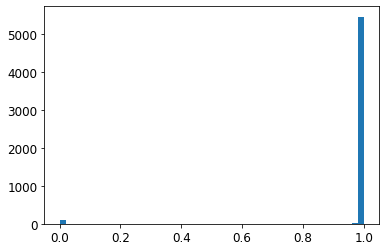

In [7]:
attenuation = 1 # 1 means no attenuation
r0=2.5
seeds = get_seeds(nodesc,100)
probs = outbreak.get_outbreaks(F, seeds.incidence, R0=r0, attenuate=attenuation)
plt.hist(probs, bins=50);

In [8]:
nodesc['probs'] = probs
mapap = pd.merge(mapa, nodesc, left_on='code_muni', right_on='tgt')

## Visualizing with Pydeck

In [9]:
DATA = ujson.loads(mapap[mapap.probs>0.5].to_json())

In [10]:

LAND_COVER = [[[-54.291, -14.139], [-54.39180562, -14.23962137], [-54.39180562, -14.23962137], [-54.291, -14.139]]]

INITIAL_VIEW_STATE = pydeck.ViewState(
  latitude=-14.23962137,
  longitude= -54.39180562,
  zoom=3,
  max_zoom=16,
  pitch=45,
  bearing=0
)

polygon = pydeck.Layer(
    'PolygonLayer',
    LAND_COVER,
    stroked=False,
    # processes the data as a flat longitude-latitude pair
    get_polygon='-',
    get_fill_color=[0, 0, 0, 20]
)

geojson = pydeck.Layer(
    'GeoJsonLayer',
    DATA,
    opacity=0.8,
    stroked=False,
    filled=True,
    extruded=True,
    wireframe=True,
#     mapbox_key='pk.eyJ1IjoiZmNjb2VsaG8iLCJhIjoiY2s4c293dzc3MGJodzNmcGEweTgxdGpudyJ9.UmSRs3e4EqTOte6jYWoaxg',
    get_elevation='properties.casos',
    get_fill_color='[properties.probs *255, 255*(1-properties.probs), properties.probs * 255]',
    get_line_color=[255, 255, 255],
    pickable=True
)

r = pydeck.Deck(
    layers=[polygon,geojson],
    initial_view_state=INITIAL_VIEW_STATE)

r.to_html()

'/home/fccoelho/Documentos/Software projects/covidash/notebooks/pydeckj3kjmizx.html'

In [11]:
cents = mapap.centroid
data2 = mapap[['casos','probs']]
data2['lon'] = copy.deepcopy([p.x for p in cents])
data2['lat'] = copy.deepcopy([p.y for p in cents])
# data2

<ipython-input-11-b3b6e5e829da>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cents = mapap.centroid
<ipython-input-11-b3b6e5e829da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['lon'] = copy.deepcopy([p.x for p in cents])
<ipython-input-11-b3b6e5e829da>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['lat'] = copy.deepcopy([p.y for p in cents])


In [12]:
layer = pydeck.Layer(
    'HexagonLayer',  # `type` positional argument is here
    data2,
    get_position=['lon', 'lat'],
    auto_highlight=True,
    elevation_scale=50,
    lower_percentile=0.8,
#     elevation_upper_percentile=1,
    get_elevation='points.probs',
    radius=3000,
    pickable=True,
    elevation_range=[0, 3000],
    extruded=True,
    coverage=3)

# Set the viewport location
view_state = pydeck.ViewState(
    longitude=-54.39180562,
    latitude=-14.23962137,
    zoom=3,
    min_zoom=3,
    max_zoom=15,
    pitch=40.5,
    bearing=-27.36)

# Combined all of it and render a viewport
r = pydeck.Deck(layers=[layer], initial_view_state=view_state)
r.to_html('hexagon-probs.html')

'/home/fccoelho/Documentos/Software projects/covidash/notebooks/hexagon-probs.html'

In [43]:
pydeck.Layer?

## Creating Animation

In [13]:
cases.date = pd.to_datetime(cases.date).dt.date
casesm = cases[(cases.place_type=='city')&(~cases.city_ibge_code.isnull())]
casesm['city_ibge_code'] = casesm.city_ibge_code.astype(int)
casesm = casesm[casesm.city_ibge_code!=0]
# casesm.fillna(0, inplace=True)
len(set(casesm.city_ibge_code))

<ipython-input-13-f41215808567>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  casesm['city_ibge_code'] = casesm.city_ibge_code.astype(int)


5535

### Creating a column for each day 
Here we apply pivot_table to cases in order to create a separate columns for each day since the beginning of the epidemic in Brasil.

In [14]:
casesw = casesm.pivot_table(index='city_ibge_code',columns='date', values='last_available_confirmed')
casesw.fillna(0, inplace=True)
# casesw.drop([0], inplace=True) #remove line with geocode 0.0
casesw

date,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,...,2020-08-17,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26
city_ibge_code,,,,,,,,,,,,,,,,,,,,,
1100015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,415.0,418.0,418.0,434.0,434.0,453.0,463.0,463.0,463.0,463.0
1100023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3786.0,3828.0,3828.0,3971.0,4024.0,4101.0,4207.0,4145.0,4145.0,4145.0
1100031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,69.0,69.0,70.0,70.0,70.0,73.0,73.0,73.0,73.0
1100049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1227.0,1309.0,1309.0,1411.0,1434.0,1461.0,1461.0,1465.0,1465.0,1465.0
1100056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,156.0,157.0,157.0,163.0,175.0,178.0,183.0,184.0,184.0,184.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5222005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,117.0,127.0,131.0,131.0,132.0,133.0,133.0,134.0,133.0,135.0
5222054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,80.0,81.0,86.0,86.0,86.0,86.0,86.0,104.0,105.0,113.0
5222203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41.0,41.0,40.0,40.0,41.0,41.0,41.0,43.0,43.0,44.0


In [15]:
mapa_serie = pd.merge(mapa,casesw, left_on='code_muni', right_on=casesw.index,how='outer')
mapa_serie.set_index('code_muni', inplace=True)
# mapa_serie.fillna(0, inplace=True)

KeyError: '2020-08-26'

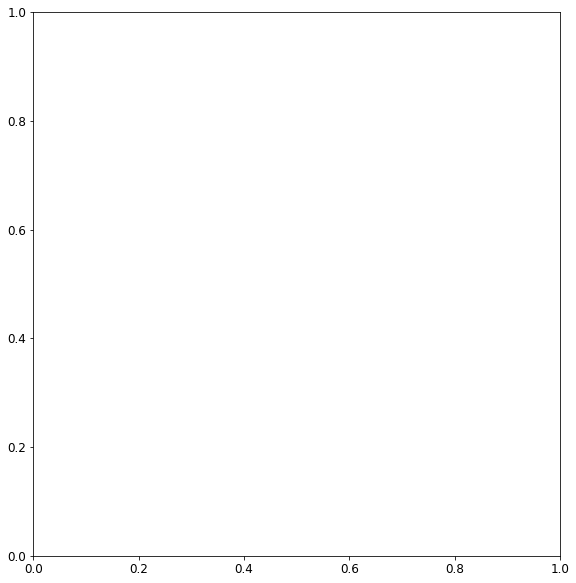

In [17]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
mapa_serie.plot(column='2020-08-26',ax=ax, cmap='Reds', legend=True,edgecolor='white',
                linewidth=0,
               scheme='user_defined', classification_kwds={'bins':[0, 10, 100, 1000, 10000]},
                legend_kwds={'loc':'upper left','bbox_to_anchor': (0.6, 1)}
               );
ax.set_axis_off()
plt.tight_layout()
plt.savefig('cases_june_21.png', dpi=300)

In [18]:
attenuation = 1 # 1 means no attenuation
r0=1.7
for D in casesw.columns:
    print(f"Processing {D}...")
    nodesC = pd.merge(nodes,casesm[casesm.date==D], left_on='tgt', right_on='city_ibge_code', how='left')
    nodesC = nodesC[['tgt','tgtname','tgt_UFCOD','tgtpop','last_available_confirmed']]
    seeds = get_seeds(nodesC,100)
#     print(len(seeds.confirmed>100))
    try:
        probs = outbreak.get_outbreaks(F, seeds.incidence, R0=r0, attenuate=attenuation)
    except:
        print(seeds)
#     print(probs.max())
    cname = 'p_'+str(D)
    nodesC[cname] = probs
    mapa_serie = pd.merge(mapa_serie, nodesC[['tgt',cname]].set_index('tgt'), left_index=True,right_index=True)

Processing 2020-02-25...
Processing 2020-02-26...
Processing 2020-02-27...
Processing 2020-02-28...
Processing 2020-02-29...
Processing 2020-03-01...
Processing 2020-03-02...
Processing 2020-03-03...
Processing 2020-03-04...
Processing 2020-03-05...
Processing 2020-03-06...
Processing 2020-03-07...
Processing 2020-03-08...
Processing 2020-03-09...
Processing 2020-03-10...
Processing 2020-03-11...
Processing 2020-03-12...
Processing 2020-03-13...
Processing 2020-03-14...
Processing 2020-03-15...
Processing 2020-03-16...
Processing 2020-03-17...
Processing 2020-03-18...
Processing 2020-03-19...
Processing 2020-03-20...
Processing 2020-03-21...
Processing 2020-03-22...
Processing 2020-03-23...
Processing 2020-03-24...
Processing 2020-03-25...
Processing 2020-03-26...
Processing 2020-03-27...
Processing 2020-03-28...
Processing 2020-03-29...
Processing 2020-03-30...
Processing 2020-03-31...
Processing 2020-04-01...
Processing 2020-04-02...
Processing 2020-04-03...
Processing 2020-04-04...


In [19]:
mapa_serie.columns = [str(c) for c in mapa_serie.columns]
mapa_serie.to_file('Probability_and_case_map_daily.gpkg', driver='GPKG')

### Gerando as Figuras

In [20]:
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)

In [ ]:
for i,D in enumerate(casesw.columns):
    if mapa_serie['p_'+str(D)].max()==0:
        continue
    fig,ax = plt.subplots(1,1, figsize=(15,15), constrained_layout=False)
    mapa_serie.plot(ax=ax,column='p_'+str(D), legend=True,
                    legend_kwds={'label': "Probabilidade",'orientation': "horizontal"})
    ax.set_title(f'Probabilidades em {D}')
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(f'anim/prob_{i}.png', dpi=200)